<a href="https://colab.research.google.com/github/zzeeddd95/capstone-project/blob/master/DecisiontreeclassifierApple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 266kB 3.4MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.18-cp36-cp36m-linux_x86_64.whl size=1531832 sha256=3c41eac97fabddf9774ae6c2a3bdc59bd2f972d3175fc7364b314708c6d9baaa
  Stored in directory: /root/.cache/pip/wheels/11/cc/88/20dc42c28a07efb297dad4303948ef6dd4a3c7257553db8f09
Successfully built ta-lib


In [78]:
import pandas as pd
import numpy as np
import pydotplus
from pylab import rcParams
import matplotlib.pyplot as plt
import talib as ta
import pandas_datareader as web
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree,metrics,preprocessing
from io import StringIO
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import f1_score,make_scorer
import graphviz
import warnings



In [26]:
#Get apple stock
apple = web.DataReader('AAPL', data_source='yahoo', start='2010-05-27', end='2020-05-27')
apple

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-05-27,36.270000,35.587143,35.799999,36.192856,166570600.0,31.332062
2010-05-28,37.057144,36.192856,37.055714,36.697144,203903700.0,31.768623
2010-06-01,37.991428,36.994286,37.098572,37.261429,219118200.0,32.257130
2010-06-02,37.828571,37.189999,37.791428,37.707142,172137000.0,32.642975
2010-06-03,37.935715,37.201427,37.882858,37.588570,162526700.0,32.540325
...,...,...,...,...,...,...
2020-05-20,319.519989,316.519989,316.679993,319.230011,27876200.0,319.230011
2020-05-21,320.890015,315.869995,318.660004,316.850006,25672200.0,316.850006
2020-05-22,319.230011,315.350006,315.769989,318.890015,20450800.0,318.890015


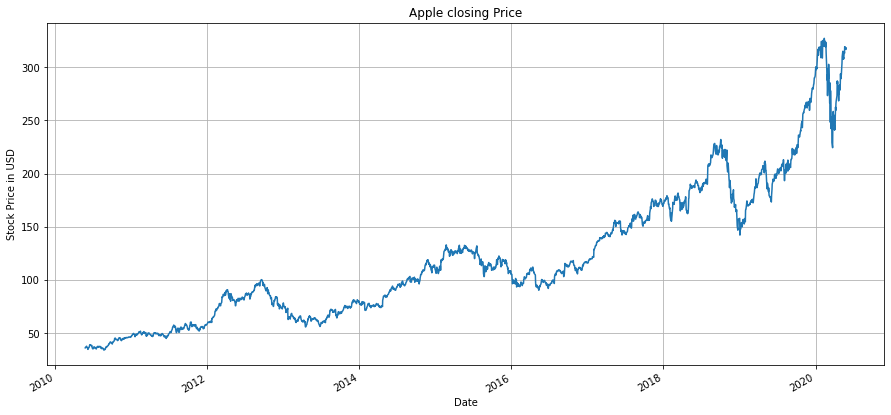

In [27]:
apple.Close.plot(figsize=(15,7))
plt.xlabel('Date')
plt.ylabel('Stock Price in USD')
plt.title("Apple closing Price")
plt.grid()
plt.show()

The underlying assumption in which a decision tree model operates on is that the input and output are correlated in some way, and so the model learns from the given input, and tries to understand what effect that input has on the output. Therefore, the predictors used here are the relative strength index, which is an oscillator that defines the momentum of the stock, and the differences between the close values over a 4 day period. The RSI reduces the close value of the stock of the past 14 days into a scale from 0-100. Typically, when RSI values are over 70, this indicates a bullish market, meaning that the market is extremely overbought and overvaluated and thus a sell off is more than likely. Alternatively, if the RSI value is under 30, this indicates an oversold market, meaning the market is due for a bullish session, and a bounce back is to be expected. 

In [28]:
# Creating the predictor and target variable

import talib as ta
apple['RSI'] = ta.RSI(apple['Close'].values, timeperiod = 14)
apple['Dif1'] = apple['Close'].diff().values
apple['Dif2'] = apple['Close'].diff(2).values
apple['Dif3'] = apple['Close'].diff(3).values
apple['Dif4'] = apple['Close'].diff(4).values

#Since the trend of the stock movement is what we are trying to predict (dependant variable), a trend column will be created as well. 
#Shift -1 is done to shift close values forward, i.e. take the close of the next day.
#A trend of 0 indicates negative return meaning close price is decreasing, whereas a trend of 1 indicates positive return meaning close price is increasing.

apple['Trend'] = np.where(apple.Close.shift(-1) > apple.Close, 1 , 0)
apple.tail()




,High,Low,Open,Close,Volume,Adj Close,RSI,Dif1,Dif2,Dif3,Dif4,Trend
Date,,,,,,,,,,,,
2020-05-20,319.519989,316.519989,316.679993,319.230011,27876200.0,319.230011,67.073985,6.089996,4.270020,11.520020,9.690002,0
2020-05-21,320.890015,315.869995,318.660004,316.850006,25672200.0,316.850006,64.740545,-2.380005,3.709991,1.890015,9.140015,1
2020-05-22,319.230011,315.350006,315.769989,318.890015,20450800.0,318.890015,65.837603,2.040009,-0.339996,5.750000,3.930023,0
2020-05-26,324.239990,316.500000,323.500000,316.730011,31380500.0,316.730011,63.581835,-2.160004,-0.119995,-2.500000,3.589996,1
2020-05-27,318.709991,313.089996,316.140015,318.109985,28236300.0,318.109985,64.420562,1.379974,-0.780029,1.259979,-1.120026,0


In [29]:
#create variable to store the target and predictor information.
#Drop Null values since this classifier does not accept them.

apple.dropna(inplace=True)
predictors = ['RSI','Dif1','Dif2','Dif3','Dif4']
independant = apple[predictors]
dependant = apple.Trend

dependant.tail()

Date
2020-05-20    0
2020-05-21    1
2020-05-22    0
2020-05-26    1
2020-05-27    0
Name: Trend, dtype: int64

In [110]:
#Splitting the data into train and test sets. 80% of data will be used to train and 20% will be used to test. Randome state paramater set to a fixed value to ensure data is split evenly for every iteration. 
#Stratified sampling is chosen over random sampling due to the need to equally distribute features between the train and test, specifically making sure that the trend values (1,0) are distributed in equal proportions between both training and testing. 

independant_train, independant_test, dependant_train, dependant_test = train_test_split(independant,dependant,test_size = 0.2, random_state = 40, stratify = dependant)
print(independant_train.shape, dependant_train.shape)
print(independant_test.shape, dependant_train.shape)

(2002, 5) (2002,)
(501, 5) (2002,)


In [123]:
#Building the classification model. The gini index is the criterion to be used because it measures the impurity of the data at a given point. 
#This gini function measures the quality of the split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

treeclf = DecisionTreeClassifier(criterion='gini', max_depth = 10, min_samples_leaf = 15)
treeclf
treefit = treeclf.fit(independant_train,dependant_train)


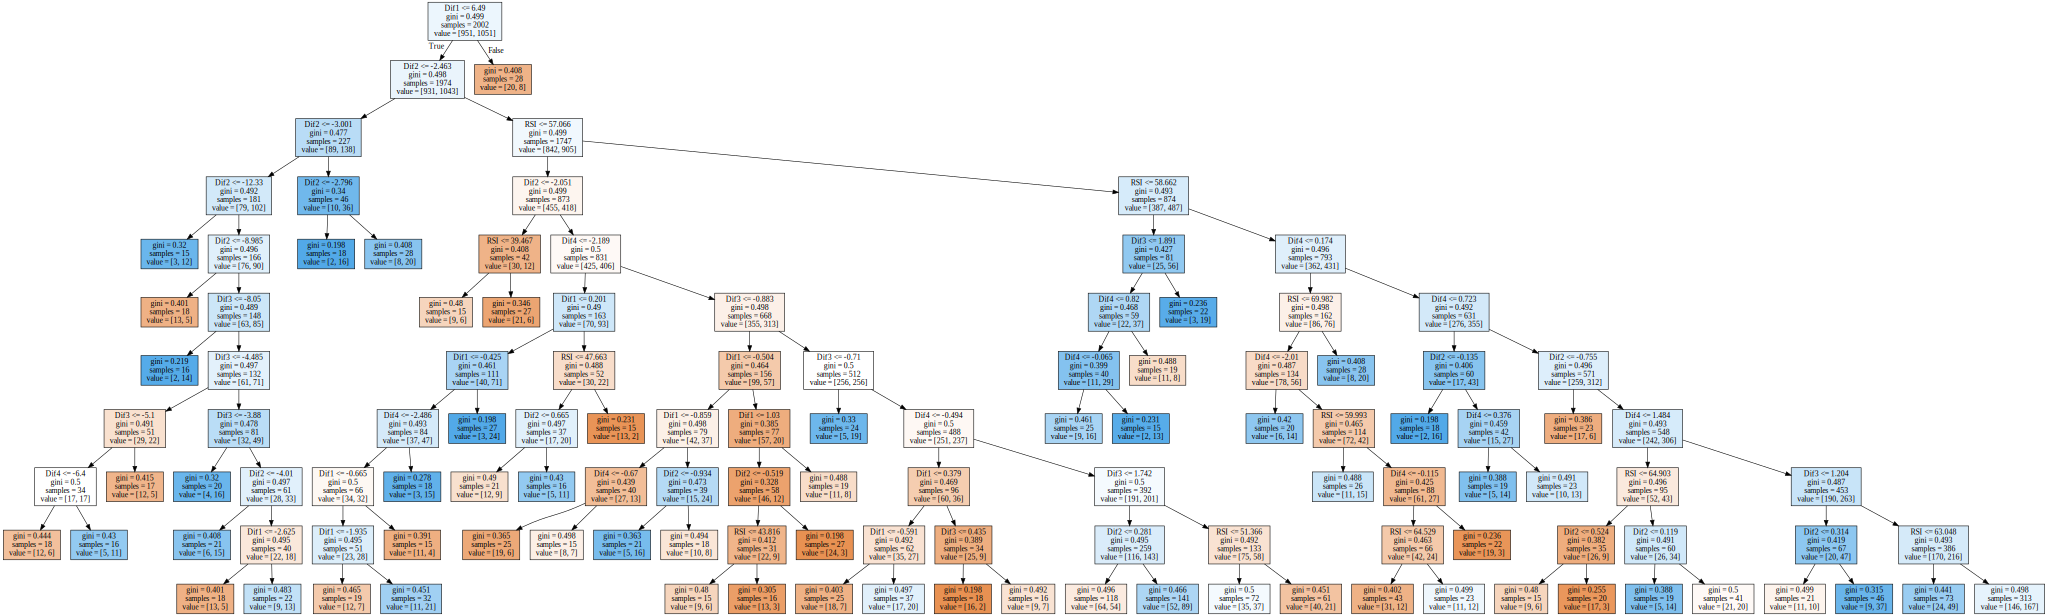

In [124]:
#Visualize the data

treeviz = tree.export_graphviz(treefit, out_file=None, filled = True, feature_names=predictors)
graphviz.Source(treeviz)

In [125]:
#Predictions are done on the test dataset and the classification report is used to evaluate the model.
#Precision and recall indicate predicion quality, f1 score provides harmonic mean of precision and recall.

predictiontest = treefit.predict(independant_test)
predictiontrain = treefit.predict(independant_train)
evaluatetest = classification_report(dependant_test,predictiontest)
evaluatetrain = classification_report(dependant_train,predictiontrain)
print('The evaluation metrics for the prediction test set are ')
print(evaluatetest)
print('The evaluation metrics for the prediction train set are  ')
print(evaluatetrain)


The evaluation metrics for the prediction test set are 
              precision    recall  f1-score   support

           0       0.46      0.39      0.43       238
           1       0.52      0.59      0.55       263

    accuracy                           0.50       501
   macro avg       0.49      0.49      0.49       501
weighted avg       0.49      0.50      0.49       501

The evaluation metrics for the prediction train set are  
              precision    recall  f1-score   support

           0       0.67      0.55      0.60       951
           1       0.65      0.75      0.70      1051

    accuracy                           0.66      2002
   macro avg       0.66      0.65      0.65      2002
weighted avg       0.66      0.66      0.65      2002



In [126]:
#Trying to improve the model

scores = cross_val_score(treefit, independant_train,dependant_train,cv=200, scoring='f1_macro')
scores.mean()
print('The training f1 score is', f1_score(predictiontrain,dependant_train))
print('The testing f1 score is', f1_score(predictiontest,dependant_test))

The training f1 score is 0.6958057395143488
The testing f1 score is 0.5490196078431373


In [92]:
#Hyperparameter tuning

paramaters = {'max_depth' : [1,2,3,4,5], 'min_samples_leaf': [1,2,3,4,5],'min_samples_split' : [2,3,4,5], 'criterion' : ['gini','entropy']}
scorer = make_scorer(f1_score)
grid_obj = GridSearchCV(treefit,paramaters,scoring=scorer)
grid_fit = grid_obj.fit(independant_train,dependant_train)
bestclassifier = grid_fit.best_estimator_
bestclassifier

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

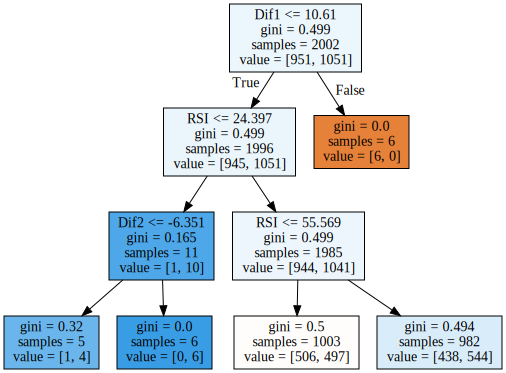

In [130]:
treeclf2 = DecisionTreeClassifier(criterion='gini', max_depth = 3, min_samples_leaf = 5, min_samples_split=10)
treefit2 = treeclf2.fit(independant_train,dependant_train)
treeviz2 = tree.export_graphviz(treefit2, out_file=None, filled = True, feature_names=predictors)
graphviz.Source(treeviz2)



In [131]:
scoresnew = cross_val_score(bestclassifier,independant_train,dependant_train,cv=10, scoring='f1_macro')
scoresnew.mean()

0.3908259851069561